In [53]:
import os
import pandas as pd
import numpy as np
import preprocessing

### Opening

In [54]:
#getting texts (this is independent of the doc2vec) This will go in the Hazelnut file
#I need to import doc2text.py
import doc2text
dirpath = "/Users/braulioantonio/Documents/Git/QMIND-knowledge-graph-project/Development/datasets/qmind_onboarding/"
files_dictionary = doc2text.get_files(dirpath)
#files_dictionary

In [55]:
corpus_data = []

for key in files_dictionary.keys():
    for file in files_dictionary[key]:
        file_metadata = doc2text.metadata(dirpath + file)
        corpus_data.append(doc2text.extract_text(dirpath+file, key) + file_metadata.all())

In [56]:
# Extract title of project
titles = [text.partition("\n")[0] for text in corpus_data]
# Delete title from each element in data
for i in range(len(corpus_data)):
    corpus_data[i] = corpus_data[i].replace(titles[i], "")

# Create df
df = pd.DataFrame(list(zip(titles, corpus_data)),columns =['title', 'desc'])
# Create text column
df["text"] = df["title"] + " " + df["desc"]
# Display
#df

### Preprocessing

In [57]:
df["clean_text"] = df["text"].apply(preprocessing.stdtextpreprocessing)
df = df[["title", "clean_text"]]
# Display
#df

### Training the Model

In [58]:
#building bag of words and tokens This will go in doc2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

text_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df["clean_text"])]

# Display the tagged docs
#text_docs


In [59]:
#Source for Hyperparameter tuning
# https://medium.com/betacom/hyperparameters-tuning-tf-idf-and-doc2vec-models-73dd418b4d

# Instantiate model
model = Doc2Vec(vector_size=64, window=5, min_count=1, workers=8, epochs=40)
# Build vocab
model.build_vocab(text_docs)
# Train model
model.train(text_docs, total_examples=model.corpus_count, epochs=model.epochs)
# Generate vectors


In [71]:
#from gensim.test.utils import get_tmpfile
#hazelnut_model = get_tmpfile("my_doc2vec_model")
model.save(os.getcwd() + '/hazelnut_model')


### Applying the model

In [60]:
proj2vec = [model.infer_vector((df['clean_text'][i].split(' '))) for i in range(0,len(df['clean_text']))]
# Display
#proj2vec
df['proj2vec'] = np.array(proj2vec).tolist()
# Display
#df

In [61]:
import tensorflow_hub as hub
# Download Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

2022-01-26 23:06:32.841910: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 23:06:32.854449: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [62]:
df['use'] = np.array(embed(df['clean_text'])).tolist()
# Display
#df

In [63]:
# Visualize Vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto',init='random')
#df['tsneP2V']  = tsne.fit_transform(X)

#Y = np.asarray( list(df['use']) )
#df['tsneUSE'] = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(Y)

In [64]:
X = np.asarray( list(df['proj2vec']) )
df_subset = pd.DataFrame()
df_subset['tsne-P2V-one'] = tsne.fit_transform(X)[:,0]
df_subset['tsne-P2V-two'] = tsne.fit_transform(X)[:,1]
X = np.asarray( list(df['use']) )
df_subset['tsne-use-one'] = tsne.fit_transform(X)[:,0]
df_subset['tsne-use-two'] = tsne.fit_transform(X)[:,1]
#training Doc2vec
#plotting #Hazelnut
#TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(X)

### Visualization

In [ ]:
import matplotlib.pyplot as plt

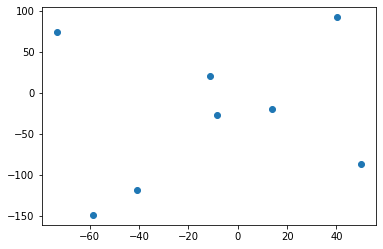

In [ ]:
#plt.figure(figsize=(16,10))
plt.scatter(
    x="tsne-P2V-one", y="tsne-P2V-two",
    data=df_subset,
)

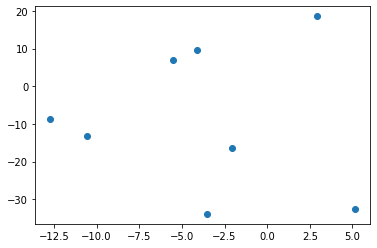

In [ ]:
#plt.figure(figsize=(16,10))
plt.scatter(
    x="tsne-use-one", y="tsne-use-two",
    data=df_subset,
)